# HDB resale flat prices  
  
Objective: To build a model that can predict prices in  5 - 10 years time, and find out what are the key factors driving house resale prices.

#### Datasets used:  
HDB resale data:  
URL: https://data.gov.sg/dataset/resale-flat-prices  
  
Consumer Price Index:  
URL: https://data.gov.sg/dataset/consumer-price-index-annual  
  
GDP Per Capita at current market prices:  
URL: https://data.gov.sg/dataset/per-capita-gni-and-per-capita-gdp-at-current-market-prices-annual


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

## 1. Reading the data

In [2]:
data90 = pd.read_csv('./data/resale-flat-prices-based-on-approval-date-1990-1999.csv')
data00 = pd.read_csv('./data/resale-flat-prices-based-on-approval-date-2000-feb-2012.csv')
data12 = pd.read_csv('./data/resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv')
data15 = pd.read_csv('./data/resale-flat-prices-based-on-registration-date-from-jan-2015-onwards.csv')

In [3]:
data90.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200


In [4]:
data90.shape

(288144, 10)

In [5]:
data00.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2000-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,159000.0
1,2000-01,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,167000.0
2,2000-01,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1976,163000.0
3,2000-01,ANG MO KIO,4 ROOM,304,ANG MO KIO AVE 1,04 TO 06,97.0,New Generation,1977,260000.0
4,2000-01,ANG MO KIO,5 ROOM,221,ANG MO KIO AVE 1,10 TO 12,127.0,Improved,1993,408000.0


In [6]:
data00.shape

(369651, 10)

In [7]:
data12.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2012-03,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,250000.0
1,2012-03,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,1980,265000.0
2,2012-03,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,06 TO 10,68.0,New Generation,1980,315000.0
3,2012-03,ANG MO KIO,3 ROOM,474,ANG MO KIO AVE 10,01 TO 05,67.0,New Generation,1984,320000.0
4,2012-03,ANG MO KIO,3 ROOM,604,ANG MO KIO AVE 5,06 TO 10,67.0,New Generation,1980,321000.0


In [8]:
data12.shape

(52203, 10)

In [9]:
data15.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,285000.0
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,290000.0
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,290000.0


In [10]:
data15.shape

(75800, 11)

In [11]:
#All datasets seem to have the same columns except data15, with an extra 'remaining_lease' column.
#Defining a function that calculates 'remaining_lease', assuming lease starts from the date in 'month' column.
def calc_remaining_lease(df):
    #Assume all lease are 99 years.
    data_year = df['month'].apply(lambda x: int(x.split('-')[0]))
    remaining_lease = 99 - (data_year - df['lease_commence_date'])
    return remaining_lease    

In [12]:
#Adding the 1st 3 datasets together
data = pd.concat((data90,data00))
data = pd.concat((data,data12))

#Adding a 'remaining_lease' column to the combined dataset from 1990 to 2014.
data['remaining_lease'] = calc_remaining_lease(data)

#All columns are the same with data15 now. Adding data15 to overall data.
data = pd.concat((data,data15))
data = data[data15.columns] #Just rearranging the columns

data

C:\Users\yitaris\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  if __name__ == '__main__':


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,86,9000.0
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,86,6000.0
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,86,8000.0
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,86,6000.0
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,85,47200.0
5,1990-01,ANG MO KIO,3 ROOM,211,ANG MO KIO AVE 3,01 TO 03,67.0,NEW GENERATION,1977,86,46000.0
6,1990-01,ANG MO KIO,3 ROOM,202,ANG MO KIO AVE 3,07 TO 09,67.0,NEW GENERATION,1977,86,42000.0
7,1990-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,10 TO 12,67.0,NEW GENERATION,1977,86,38000.0
8,1990-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,04 TO 06,67.0,NEW GENERATION,1977,86,40000.0
9,1990-01,ANG MO KIO,3 ROOM,232,ANG MO KIO AVE 3,01 TO 03,67.0,NEW GENERATION,1977,86,47000.0


In [13]:
data.shape

(785798, 11)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785798 entries, 0 to 75799
Data columns (total 11 columns):
month                  785798 non-null object
town                   785798 non-null object
flat_type              785798 non-null object
block                  785798 non-null object
street_name            785798 non-null object
storey_range           785798 non-null object
floor_area_sqm         785798 non-null float64
flat_model             785798 non-null object
lease_commence_date    785798 non-null int64
remaining_lease        785798 non-null int64
resale_price           785798 non-null float64
dtypes: float64(2), int64(2), object(7)
memory usage: 71.9+ MB


In [15]:
data.describe()

,floor_area_sqm,lease_commence_date,remaining_lease,resale_price
count,785798.000000,785798.000000,785798.000000,7.857980e+05
mean,95.527087,1986.716652,82.248419,2.858402e+05
std,26.176702,8.995981,9.463362,1.447454e+05
min,28.000000,1966.000000,47.000000,5.000000e+03
25%,72.000000,1980.000000,76.000000,1.760000e+05
50%,93.000000,1985.000000,84.000000,2.680000e+05
75%,114.000000,1993.000000,90.000000,3.750000e+05
max,307.000000,2016.000000,101.000000,1.185000e+06


In [16]:
#Why are there entries with remaining_lease over 99?
strange_lease = data[data['remaining_lease']>99]
strange_lease

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
23474,1991-11,BISHAN,4 ROOM,227,BISHAN ST 23,04 TO 06,103.0,MODEL A,1992,100,135000.0
34509,1992-08,TAMPINES,5 ROOM,476,TAMPINES ST 44,04 TO 06,132.0,MODEL A,1993,100,200000.0
46878,1993-06,WOODLANDS,5 ROOM,321,WOODLANDS ST 32,01 TO 03,127.0,IMPROVED,1994,100,145000.0
69475,1994-05,CHOA CHU KANG,EXECUTIVE,528,CHOA CHU KANG ST 51,07 TO 09,153.0,APARTMENT,1995,100,350000.0
70056,1994-05,PASIR RIS,4 ROOM,631,PASIR RIS DR 3,10 TO 12,104.0,MODEL A,1995,100,160000.0
70439,1994-05,TAMPINES,EXECUTIVE,332,TAMPINES ST 32,04 TO 06,147.0,APARTMENT,1996,101,356000.0
72165,1994-06,PASIR RIS,4 ROOM,143,PASIR RIS ST 11,04 TO 06,105.0,MODEL A,1995,100,180000.0
76889,1994-08,WOODLANDS,EXECUTIVE,136,MARSILING RD,01 TO 03,173.0,APARTMENT,1995,100,330000.0
77768,1994-09,CHOA CHU KANG,5 ROOM,503,CHOA CHU KANG ST 51,13 TO 15,127.0,IMPROVED,1995,100,235000.0
78371,1994-09,QUEENSTOWN,EXECUTIVE,150,MEI LING ST,10 TO 12,142.0,APARTMENT,1995,100,532000.0


In [17]:
#What's the newest flat with remaining lease over 99 years?
strange_lease['lease_commence_date'].max()

2012

In [18]:
#How many entries in my dataset contain this weird value?
len(strange_lease)

51

The strange lease_commence_date of over 99 year leases mostly appear in the 1990-2000 and 2000-2012 dataset, with no such issues for the later dates. On closer inspection, this is because the dates in the 'month' category came before the lease commencement date.  
  
This is likely due to the difference between 'Approval Date' and 'Registration Date', which means that the 'month' column actually means different things for the 1990-2000 and 2000-2012 datasets, compared to the 2012-2015 dataset and the 2015-onwards dataset.  

<b>Assumption 1:</b> We'll assume that the difference between 'Approval Date' and 'Registration Date' don't differ more than 1 year, which means my calculations will not differ by more than 1 year. Hopefully, the effects on the sales prices is minimal.  
  
For the 51 rows, we'll assume these are new flats with 99 years lease remaining, and replace the values as such.

In [19]:
data.loc[data['remaining_lease']>99,'remaining_lease'] = 99

In [20]:
#Taking a quick look at the unique values in each column.
for n in data.columns:
    print(n)
    print(data[n].unique())

month
['1990-01' '1990-02' '1990-03' '1990-04' '1990-05' '1990-06' '1990-07'
 '1990-08' '1990-09' '1990-10' '1990-11' '1990-12' '1991-01' '1991-02'
 '1991-03' '1991-04' '1991-05' '1991-06' '1991-07' '1991-08' '1991-09'
 '1991-10' '1991-11' '1991-12' '1992-01' '1992-02' '1992-03' '1992-04'
 '1992-05' '1992-06' '1992-07' '1992-08' '1992-09' '1992-10' '1992-11'
 '1992-12' '1993-01' '1993-02' '1993-03' '1993-04' '1993-05' '1993-06'
 '1993-07' '1993-08' '1993-09' '1993-10' '1993-11' '1993-12' '1994-01'
 '1994-02' '1994-03' '1994-04' '1994-05' '1994-06' '1994-07' '1994-08'
 '1994-09' '1994-10' '1994-11' '1994-12' '1995-01' '1995-02' '1995-03'
 '1995-04' '1995-05' '1995-06' '1995-07' '1995-08' '1995-09' '1995-10'
 '1995-11' '1995-12' '1996-01' '1996-02' '1996-03' '1996-04' '1996-05'
 '1996-06' '1996-07' '1996-08' '1996-09' '1996-10' '1996-11' '1996-12'
 '1997-01' '1997-02' '1997-03' '1997-04' '1997-05' '1997-06' '1997-07'
 '1997-08' '1997-09' '1997-10' '1997-11' '1997-12' '1998-01' '1998-02'


['10 TO 12' '04 TO 06' '07 TO 09' '01 TO 03' '13 TO 15' '19 TO 21'
 '16 TO 18' '25 TO 27' '22 TO 24' '28 TO 30' '31 TO 33' '40 TO 42'
 '37 TO 39' '34 TO 36' '06 TO 10' '01 TO 05' '11 TO 15' '16 TO 20'
 '21 TO 25' '26 TO 30' '36 TO 40' '31 TO 35' '46 TO 48' '43 TO 45'
 '49 TO 51']
floor_area_sqm
[ 31.   73.   67.   82.   74.   88.   89.   83.   68.   75.   81.   91.
  92.   97.   90.   98.   99.  100.   93.  103.  117.  119.  120.  118.
 121.  135.   45.   65.   59.   70.   76.   84.  104.  105.  125.  123.
 132.  139.  143.  151.   69.  106.  107.  116.  149.  154.  141.  146.
 150.  148.  145.   29.   51.   61.   72.   58.   66.   63.   60.   53.
  54.   64.   56.   77.  115.  133.  131.  126.   43.   38.   41.   85.
 111.  101.  112.  137.  134.  127.  147.  163.   50.   40.   60.3  62.
  55.   57.   52.   63.1 102.   94.   83.1 140.  142.   71.  108.  144.
  96.  114.  173.  157.  152.  155.   87.  109.  110.  122.  128.   78.
  46.   42.   49.   47.  138.   86.  156.   79.   80.  1

In [21]:
#Presence of mixture of upper case and mixed case characters in 'flat_model'. Changing all to upper case for consistency
data['flat_model'] = data['flat_model'].str.upper()
data.loc[data['flat_model'] == 'PREMIUM APARTMENT.','flat_model'] = 'PREMIUM APARTMENT'
data['flat_model'].unique()

array(['IMPROVED', 'NEW GENERATION', 'STANDARD', 'MODEL A', 'SIMPLIFIED',
       'MODEL A-MAISONETTE', 'APARTMENT', 'MAISONETTE', 'ADJOINED FLAT',
       'TERRACE', '2-ROOM', 'IMPROVED-MAISONETTE', 'MULTI GENERATION',
       'PREMIUM APARTMENT', 'PREMIUM MAISONETTE', 'MODEL A2', 'DBSS',
       'TYPE S1', 'TYPE S2', 'PREMIUM APARTMENT LOFT'], dtype=object)

In [22]:
#Converting 'month' to datetime format, also renaming it 'date' to avoid confusion. Also adding separate 'year' and 'month' columns.
data['date'] = pd.to_datetime(data['month'], format = '%Y-%m')
data['year'] = data['date'].apply(lambda x:x.year)
data['month'] = data['date'].apply(lambda x:x.month)

In [23]:
#Taking a subset of this data to reduce the amount of computer resources needed for my models later.
data = data[data['year']>2011]
data.shape

(131191, 13)

<b>Assumption 2:</b> Resale prices have not been adjusted for inflation. Additional data needed to update the prices to be consistent with 2018 prices.

In [24]:
#Loading CPI data
cpi = pd.read_csv('./data/consumer-price-index-at-division-level-base-year-2014-100-annual.csv')

In [25]:
cpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 4 columns):
year       684 non-null int64
level_1    684 non-null object
level_2    684 non-null object
value      684 non-null object
dtypes: int64(1), object(3)
memory usage: 21.5+ KB


In [26]:
for n in cpi.columns:
    print(n)
    print(cpi[n].unique())

year
[1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017]
level_1
['All Items']
level_2
['Food' 'Food Excl Food Servicing Services' 'Food Servicing Services'
 'Clothing & Footwear' 'Housing & Utilities'
 'Household Durables And Services' 'Health Care' 'Transport'
 'Communication' 'Recreation & Culture' 'Education'
 'Miscellaneous Goods & Services']
value
['23.73' 'na' '54.685' '23.51' '33.34' '19.863' '20.318' '87.887' '51.022'
 '17.211' '19.138' '23.898' '54.423' '23.652' '33.386' '19.872' '20.303'
 '17.275' '19.131' '24.773' '54.245' '23.703' '32.704' '20.32' '50.972'
 '17.834' '19.128' '25.397' '54.558' '24.138' '32.784' '20.389' '95.211'
 '18.026' '18.887' '25.279' '55.236' '24.584' '33.581' '131.831' '17.609'
 '19.216' '25.982' '56.175' '24.444' '

In [27]:
#We're only interested in 1990 - present, and 'Housing & Utilities' to adjust housing prices. Dropping everything else.
cpi = cpi[cpi['level_2']=='Housing & Utilities']
cpi = cpi.drop(cpi.index[cpi['year']<1990])

In [28]:
cpi.head()

,year,level_1,level_2,value
352,1990,All Items,Housing & Utilities,54.707
364,1991,All Items,Housing & Utilities,55.963
376,1992,All Items,Housing & Utilities,57.403
388,1993,All Items,Housing & Utilities,59.503
400,1994,All Items,Housing & Utilities,60.323


In [29]:
#Once we got the info we need, we no longer need 'level_1' and 'level_2' columns
cpi_housing = cpi[['year','value']]

In [30]:
#This dataset isn't updated with 2018 numbers. However, from https://tradingeconomics.com/singapore/cpi-housing-utilities,
#we know that the CPI for housing and utilities in 2018 is 88.2. Updating that in the dataset.
cpi_housing = cpi_housing.append({'year':2018, 'value':88.2}, ignore_index=True)

In [31]:
cpi_housing['year'] = cpi_housing['year'].astype(int)
cpi_housing['value'] = cpi_housing['value'].astype(float)

In [32]:
#Changing cpi_housing to dictionary for easier access to the CPI values.
cpi_dict = cpi_housing.set_index('year').to_dict()
cpi_dict = cpi_dict['value']
cpi_dict

{1990: 54.707,
 1991: 55.963,
 1992: 57.403,
 1993: 59.503,
 1994: 60.323,
 1995: 60.914,
 1996: 61.481,
 1997: 63.279,
 1998: 64.906,
 1999: 64.084,
 2000: 65.886,
 2001: 67.156,
 2002: 65.679,
 2003: 65.458,
 2004: 65.392,
 2005: 66.218,
 2006: 68.394,
 2007: 68.552,
 2008: 78.825,
 2009: 80.388,
 2010: 82.189,
 2011: 89.585,
 2012: 97.122,
 2013: 99.886,
 2014: 99.999,
 2015: 96.459,
 2016: 92.526,
 2017: 90.181,
 2018: 88.2}

Now that we have a list of years and the corresponding CPI, we can convert the resale prices in the main dataset to 2018 values.

In [33]:
data['ratio'] = 88.2/(data['year'].apply(lambda x:cpi_dict[x]))
data['resale_price'] = (data['resale_price']*data['ratio']).round() #Rounding to nearest whole figure
data.drop('ratio', axis=1, inplace = True)

C:\Users\yitaris\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\yitaris\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\yitaris\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

<b>Assumption 3:</b> Resale prices are affected by general performance of Singapore's economy. GDP per capita data used here to represent the state of the economy.

In [34]:
gdp = pd.read_csv('./data/per-capita-gni-and-per-capita-gdp-at-current-market-prices-in-usd-annual.csv')

In [35]:
gdp

,year,level_1,value
0,1960,Per Capita GNI (US Dollar),436
1,1960,Per Capita GDP (US Dollar),428
2,1961,Per Capita GNI (US Dollar),458
3,1961,Per Capita GDP (US Dollar),449
4,1962,Per Capita GNI (US Dollar),481
5,1962,Per Capita GDP (US Dollar),472
6,1963,Per Capita GNI (US Dollar),523
7,1963,Per Capita GDP (US Dollar),511
8,1964,Per Capita GNI (US Dollar),501
9,1964,Per Capita GDP (US Dollar),485


In [36]:
#We're only interested in 1990 - present, and 'Per Capita GDP'. Dropping everything else.
gdp = gdp[gdp['level_1']=='Per Capita GDP (US Dollar)']
gdp = gdp.drop(gdp.index[gdp['year']<1990])
gdp.head()

,year,level_1,value
61,1990,Per Capita GDP (US Dollar),12766
63,1991,Per Capita GDP (US Dollar),14504
65,1992,Per Capita GDP (US Dollar),16144
67,1993,Per Capita GDP (US Dollar),18302
69,1994,Per Capita GDP (US Dollar),21578


In [37]:
#Again, once we have what we need, 'level_1' can be dropped
gdp = gdp[['year','value']]

In [38]:
#converting to dictionary.
gdp_dict = gdp.set_index('year').to_dict()['value']

In [39]:
#Years 2017 and 2018 are missing from this dataset. Topping up from https://tradingeconomics.com/singapore/gdp-per-capita
gdp_dict[2017] = 53354
gdp_dict[2018] = 55236

In [40]:
gdp_dict

{1990: 12766,
 1991: 14504,
 1992: 16144,
 1993: 18302,
 1994: 21578,
 1995: 24937,
 1996: 26261,
 1997: 26387,
 1998: 21824,
 1999: 21797,
 2000: 23794,
 2001: 21577,
 2002: 22017,
 2003: 23574,
 2004: 27403,
 2005: 29866,
 2006: 33580,
 2007: 39224,
 2008: 39724,
 2009: 38578,
 2010: 46570,
 2011: 53162,
 2012: 54431,
 2013: 56029,
 2014: 56337,
 2015: 53630,
 2016: 52962,
 2017: 53354,
 2018: 55236}

In [41]:
data['gdp_per_capita'] = data['year'].apply(lambda x: gdp_dict[x])

C:\Users\yitaris\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [42]:
#Dropping duplicates if any
data.drop_duplicates(inplace=True)

C:\Users\yitaris\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
data

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,date,year,gdp_per_capita
366463,1,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,NEW GENERATION,1976,63,340551.0,2012-01-01,2012,54431
366464,1,ANG MO KIO,4 ROOM,304,ANG MO KIO AVE 1,10 TO 12,97.0,NEW GENERATION,1977,64,472231.0,2012-01-01,2012,54431
366465,1,ANG MO KIO,5 ROOM,306,ANG MO KIO AVE 1,01 TO 03,123.0,STANDARD,1977,64,508556.0,2012-01-01,2012,54431
366466,1,ANG MO KIO,3 ROOM,332,ANG MO KIO AVE 1,10 TO 12,68.0,NEW GENERATION,1981,68,317848.0,2012-01-01,2012,54431
366467,1,ANG MO KIO,4 ROOM,336,ANG MO KIO AVE 1,07 TO 09,91.0,NEW GENERATION,1982,69,435905.0,2012-01-01,2012,54431
366468,1,ANG MO KIO,4 ROOM,335,ANG MO KIO AVE 1,01 TO 03,91.0,NEW GENERATION,1982,69,417743.0,2012-01-01,2012,54431
366469,1,ANG MO KIO,3 ROOM,418,ANG MO KIO AVE 10,04 TO 06,89.0,NEW GENERATION,1979,66,381417.0,2012-01-01,2012,54431
366470,1,ANG MO KIO,3 ROOM,440,ANG MO KIO AVE 10,10 TO 12,67.0,NEW GENERATION,1979,66,313307.0,2012-01-01,2012,54431
366471,1,ANG MO KIO,3 ROOM,432,ANG MO KIO AVE 10,07 TO 09,82.0,NEW GENERATION,1979,66,336010.0,2012-01-01,2012,54431
366472,1,ANG MO KIO,4 ROOM,470,ANG MO KIO AVE 10,04 TO 06,92.0,NEW GENERATION,1979,66,395039.0,2012-01-01,2012,54431


In [44]:
#writing to csv
#data.to_csv('./data/adjusted_data.csv', index=False)

## 2. EDA

#### a. Looking at numerical data

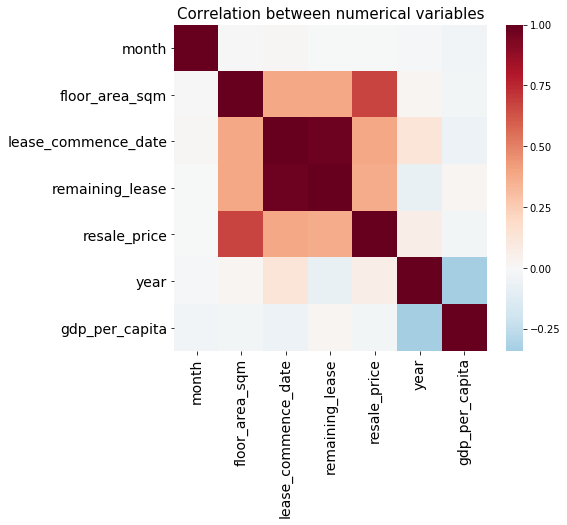

In [86]:
#Checking for any correlation
fig,ax = plt.subplots(figsize=(7,6))
sns.heatmap(data.corr(), cmap='RdBu_r', center=0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Correlation between numerical variables', fontsize = 15)
plt.show()

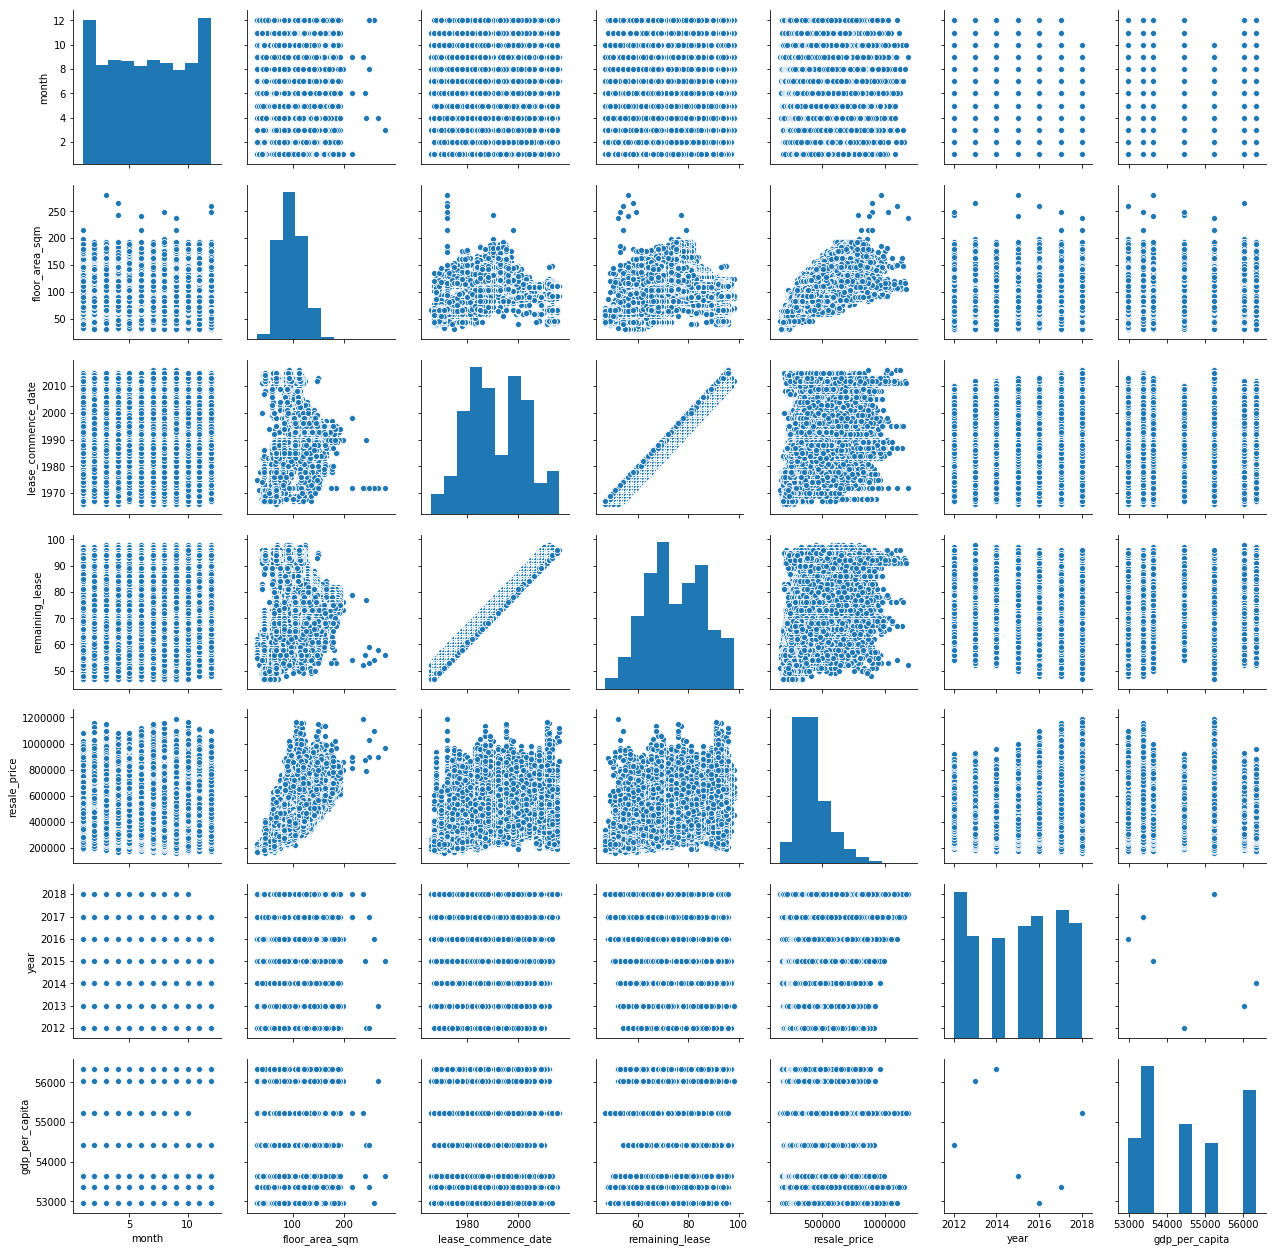

In [46]:
sns.pairplot(data, x_vars=["month", "floor_area_sqm","lease_commence_date","remaining_lease","resale_price","year","gdp_per_capita"], y_vars=["month", "floor_area_sqm","lease_commence_date","remaining_lease","resale_price","year","gdp_per_capita"])

<b>Insights: </b> Pretty strong correlation between floor_area_sqm and resale_price. Some correlation between resale_price and year, as well as with gdp_per_capita. It's worth noting that gdp_per_capita and year itself have a positive relationship; generally increasing over time. 

#### b. Looking at categorical data - general price trends

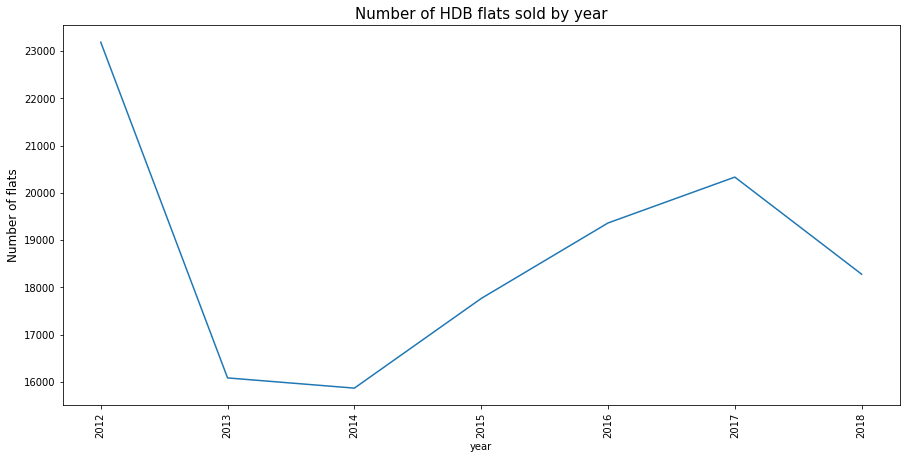

In [47]:
#How many HDB resale flats are sold over the years?
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['year'])['resale_price'].count().plot.line()
plt.title('Number of HDB flats sold by year', fontsize=15)
plt.ylabel('Number of flats', fontsize =12)
plt.xticks(range(2012,2019), rotation=90)
plt.show()

In [48]:
data['town'].unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
       'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN'], dtype=object)

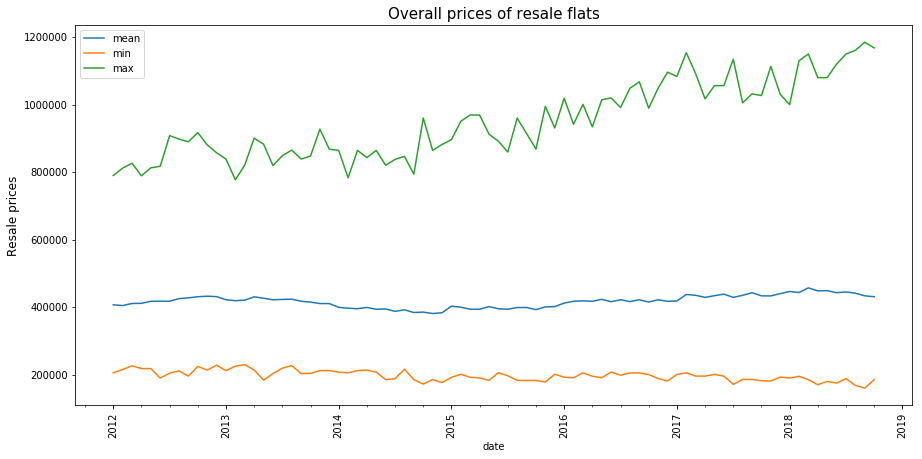

In [49]:
#What about general trend of prices?
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['date'])['resale_price'].mean().plot.line(label = 'mean')
data.groupby(['date'])['resale_price'].min().plot.line(label = 'min')
data.groupby(['date'])['resale_price'].max().plot.line(label= 'max')
plt.title('Overall prices of resale flats', fontsize=15)
plt.ylabel('Resale prices', fontsize =12)
plt.xticks(rotation=90)
plt.legend()
plt.show()

<b>Insights: </b>As seen here as well as our pairplot earlier, there is a general upwards trend over time. The trend is more pronounced for the most expensive flats, as shown in the 'max' plot, while prices for cheaper flats rose at a slower rate as shown in the 'min' plot. There's a strange spike in housing prices around 1996-1997. This isn't explained in the data, but given that that's right before the 1997 Asian Financial Crisis, we can infer that the original trend was a much faster rise in prices, before the effects of the crisis caused the prices to plunge back down.

C:\Users\yitaris\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


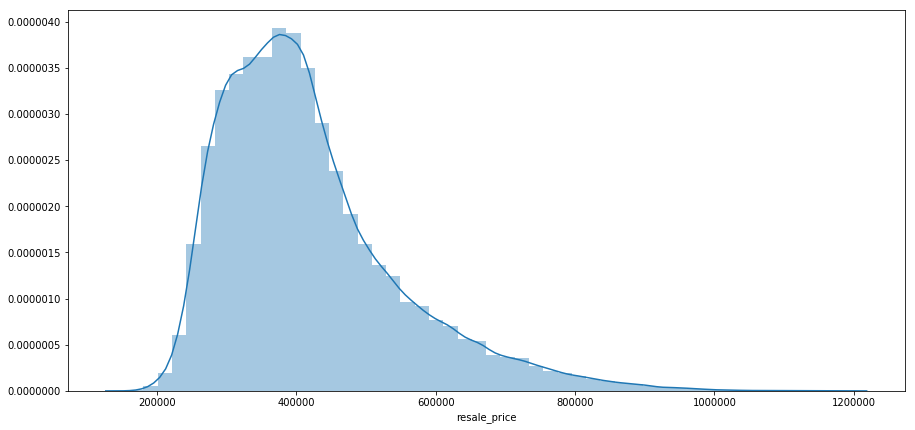

In [50]:
#Looking at resale_price distribution
fig,ax = plt.subplots(figsize=(15,7))
sns.distplot(data['resale_price'])

#### c. Looking at categorical data - by town

Text(0.5,1,'No. of units sold by town')

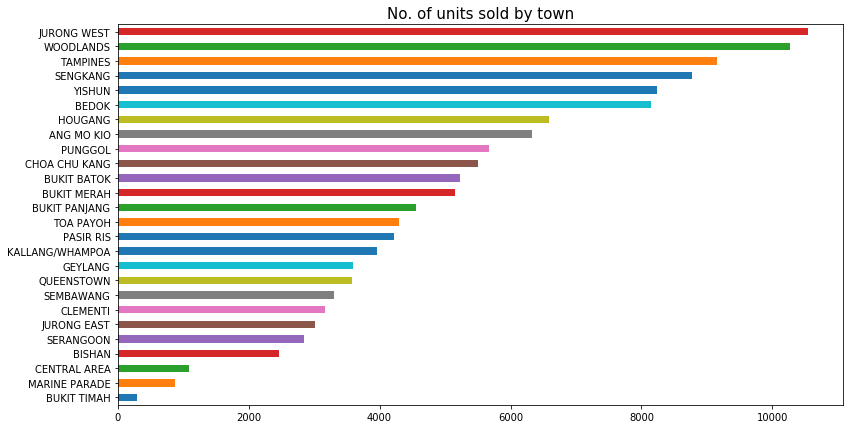

In [51]:
#How many units sold?
fig, ax = plt.subplots(figsize=(13,7))
data['town'].value_counts().sort_values(ascending=True).plot.barh()
plt.title('No. of units sold by town', fontsize=15)

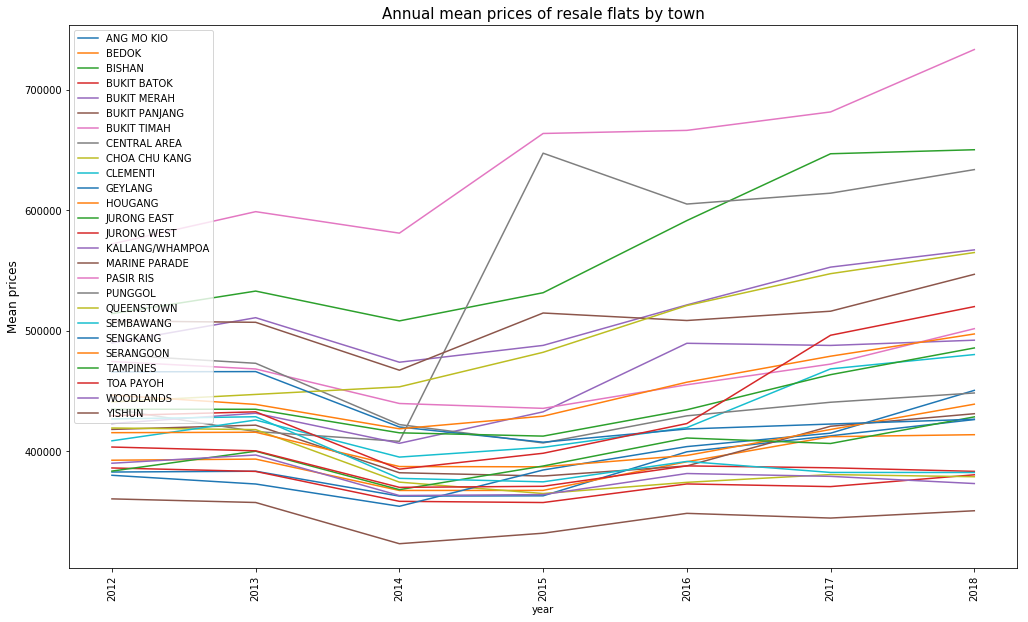

In [52]:
#Any differences in prices of flats by town?
fig, ax = plt.subplots(figsize=(17,10))
by_town = data.groupby(['town','year'])['resale_price'].mean()
by_town.reset_index().pivot(index='year',columns='town',values='resale_price').plot.line(ax=ax)
plt.title('Annual mean prices of resale flats by town', fontsize=15)
plt.ylabel('Mean prices', fontsize =12)
plt.xticks(range(2012,2019), rotation=90)
plt.legend(loc = 'upper left')
plt.show()

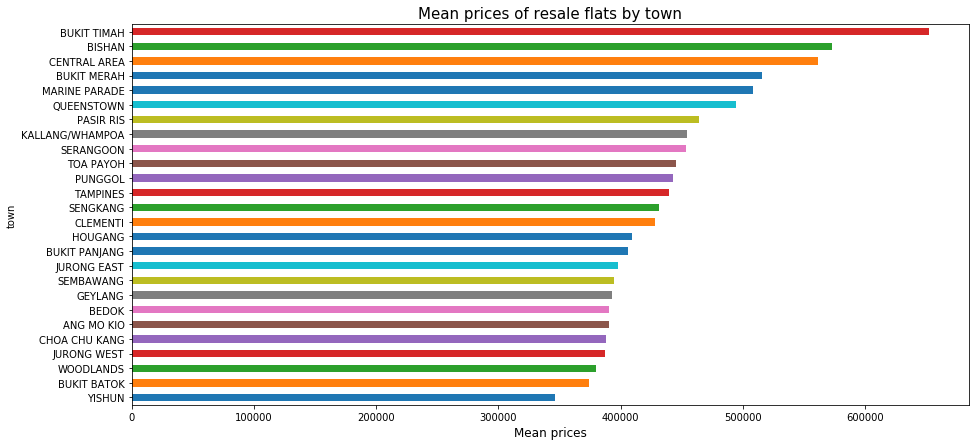

In [53]:
#Most expensive towns since 2005?
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['town'])['resale_price'].mean().sort_values().plot.barh()
plt.title('Mean prices of resale flats by town', fontsize=15)
plt.xlabel('Mean prices', fontsize =12)
plt.show()

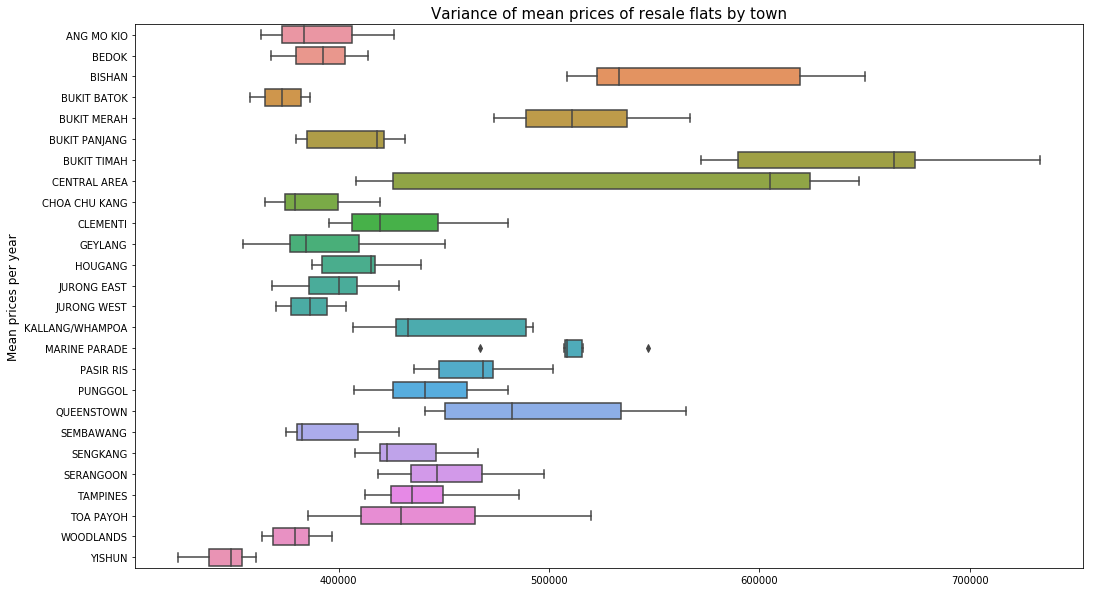

In [54]:
#Variance of prices by different towns from 2005 to 2018
fig, ax = plt.subplots(figsize=(17,10))
subset_group = data.groupby(['town','year'])[['resale_price']].mean().reset_index()
sns.boxplot(data = subset_group.pivot(index='year',columns='town',values='resale_price'), orient = 'h')
plt.title('Variance of mean prices of resale flats by town', fontsize=15)
plt.ylabel('Mean prices per year', fontsize =12)
plt.show()

In [55]:
#Outliers present for Marine Parade.
data[(data['town']=='MARINE PARADE') & ((data['resale_price']>530000)|(data['resale_price']<500000))]

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,date,year,gdp_per_capita
367320,1,MARINE PARADE,3 ROOM,33,MARINE CRES,04 TO 06,65.0,IMPROVED,1975,62,357806.0,2012-01-01,2012,54431
367321,1,MARINE PARADE,3 ROOM,31,MARINE CRES,07 TO 09,65.0,IMPROVED,1975,62,393121.0,2012-01-01,2012,54431
367322,1,MARINE PARADE,3 ROOM,65,MARINE DR,07 TO 09,76.0,IMPROVED,1976,63,435905.0,2012-01-01,2012,54431
367323,1,MARINE PARADE,5 ROOM,73,MARINE DR,22 TO 24,120.0,STANDARD,1977,64,750120.0,2012-01-01,2012,54431
367324,1,MARINE PARADE,5 ROOM,72,MARINE DR,22 TO 24,117.0,STANDARD,1977,64,744672.0,2012-01-01,2012,54431
367325,1,MARINE PARADE,5 ROOM,1,MARINE TER,19 TO 21,120.0,STANDARD,1975,62,735590.0,2012-01-01,2012,54431
368885,2,MARINE PARADE,5 ROOM,44,MARINE CRES,07 TO 09,117.0,STANDARD,1975,62,681102.0,2012-02-01,2012,54431
368886,2,MARINE PARADE,4 ROOM,62,MARINE DR,04 TO 06,87.0,IMPROVED,1976,63,483128.0,2012-02-01,2012,54431
368887,2,MARINE PARADE,3 ROOM,66,MARINE DR,16 TO 18,76.0,IMPROVED,1976,63,425008.0,2012-02-01,2012,54431
368888,2,MARINE PARADE,3 ROOM,67,MARINE DR,04 TO 06,65.0,IMPROVED,1976,63,367795.0,2012-02-01,2012,54431


In [56]:
data[(data['town']=='MARINE PARADE') & ((data['resale_price']>530000)|(data['resale_price']<500000))].describe()
#Over 800+ flats in Marine Parade are sold at over $530,000 or under $500,000. 

,month,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,year,gdp_per_capita
count,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000
mean,6.471883,85.662592,1975.381418,59.191932,507979.826406,2014.816626,54627.326406
std,3.304211,22.992811,0.644150,2.469611,168118.339770,2.012353,1238.571986
min,1.000000,42.000000,1975.000000,55.000000,180000.000000,2012.000000,52962.000000
25%,4.000000,65.000000,1975.000000,57.000000,377927.000000,2013.000000,53354.000000
50%,6.000000,76.000000,1975.000000,60.000000,446360.500000,2015.000000,54431.000000
75%,9.000000,117.000000,1976.000000,61.000000,664526.750000,2017.000000,56029.000000
max,12.000000,147.000000,1978.000000,65.000000,950000.000000,2018.000000,56337.000000


In [57]:
#Relationship between prices and the no. of units sold?
subset_group = data.groupby(['town'])['resale_price']
np.corrcoef(subset_group.mean(), subset_group.count())

array([[ 1.        , -0.64275809],
       [-0.64275809,  1.        ]])

<b>Insights: </b>In general there are clear differences in level of pricing between the different townships, although the variance is big enough such that town is not the deciding factor in prices. There is a general upwards trend over time as well, but we already covered that in the pairplot earlier.

#### d. Looking at categorical data - by Flat Types

Text(0.5,1,'No. of units sold by type')

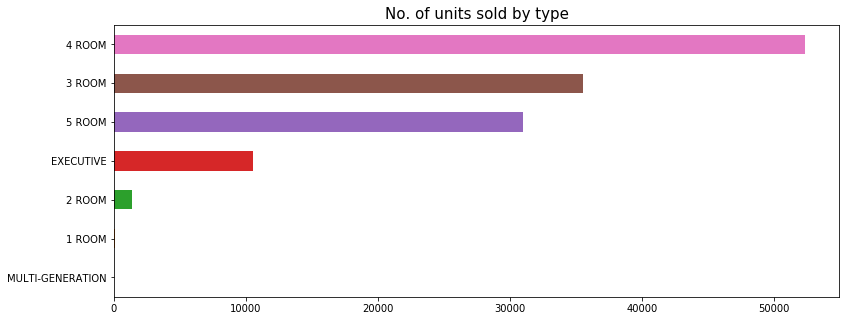

In [58]:
#How many units sold?
fig, ax = plt.subplots(figsize=(13,5))
data['flat_type'].value_counts().sort_values(ascending=True).plot.barh()
plt.title('No. of units sold by type', fontsize=15)

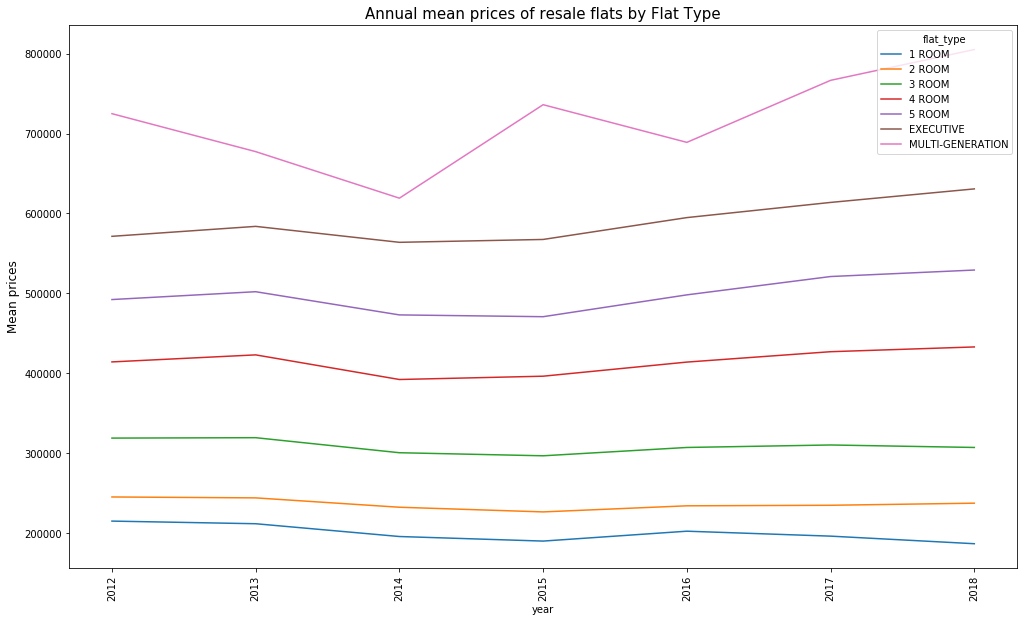

In [59]:
#Any differences in prices of flats by flat_type?
fig, ax = plt.subplots(figsize=(17,10))
by_type = data.groupby(['flat_type','year'])['resale_price'].mean()
by_type.reset_index().pivot(index='year',columns='flat_type',values='resale_price').plot.line(ax=ax)
plt.title('Annual mean prices of resale flats by Flat Type', fontsize=15)
plt.ylabel('Mean prices', fontsize =12)
plt.xticks(range(2012,2019), rotation=90)
plt.show()

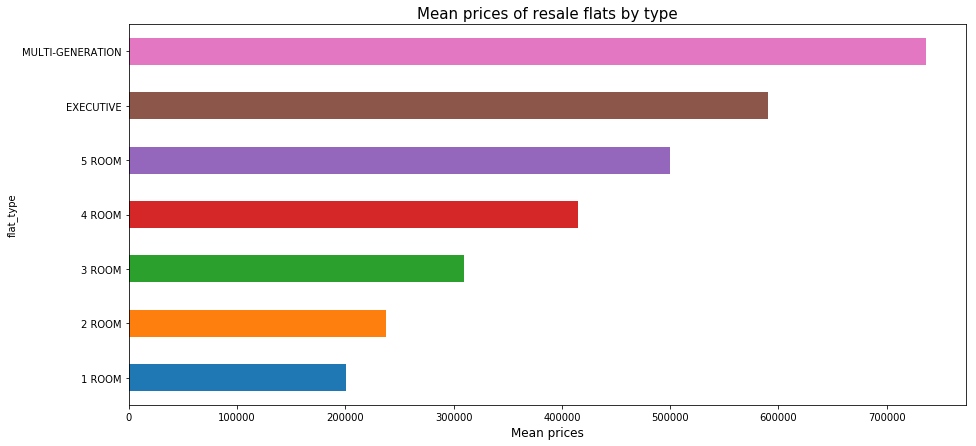

In [60]:
#Mean prices by flat_types
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['flat_type'])['resale_price'].mean().sort_values().plot.barh()
plt.title('Mean prices of resale flats by type', fontsize=15)
plt.xlabel('Mean prices', fontsize =12)
plt.show()

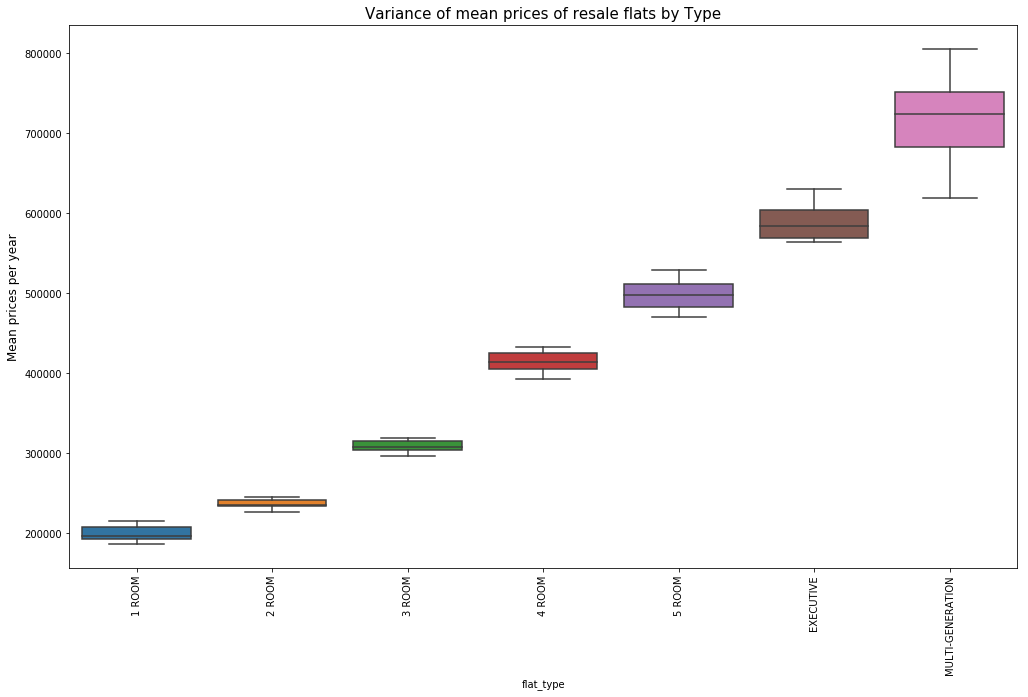

In [61]:
#Variance of prices by flat_types
fig, ax = plt.subplots(figsize=(17,10))
subset_group = data.groupby(['flat_type','year'])[['resale_price']].mean().reset_index()
sns.boxplot(data = subset_group.pivot(index='year',columns='flat_type',values='resale_price'))
plt.title('Variance of mean prices of resale flats by Type', fontsize=15)
plt.ylabel('Mean prices per year', fontsize =12)
plt.xticks(rotation=90)
plt.show()

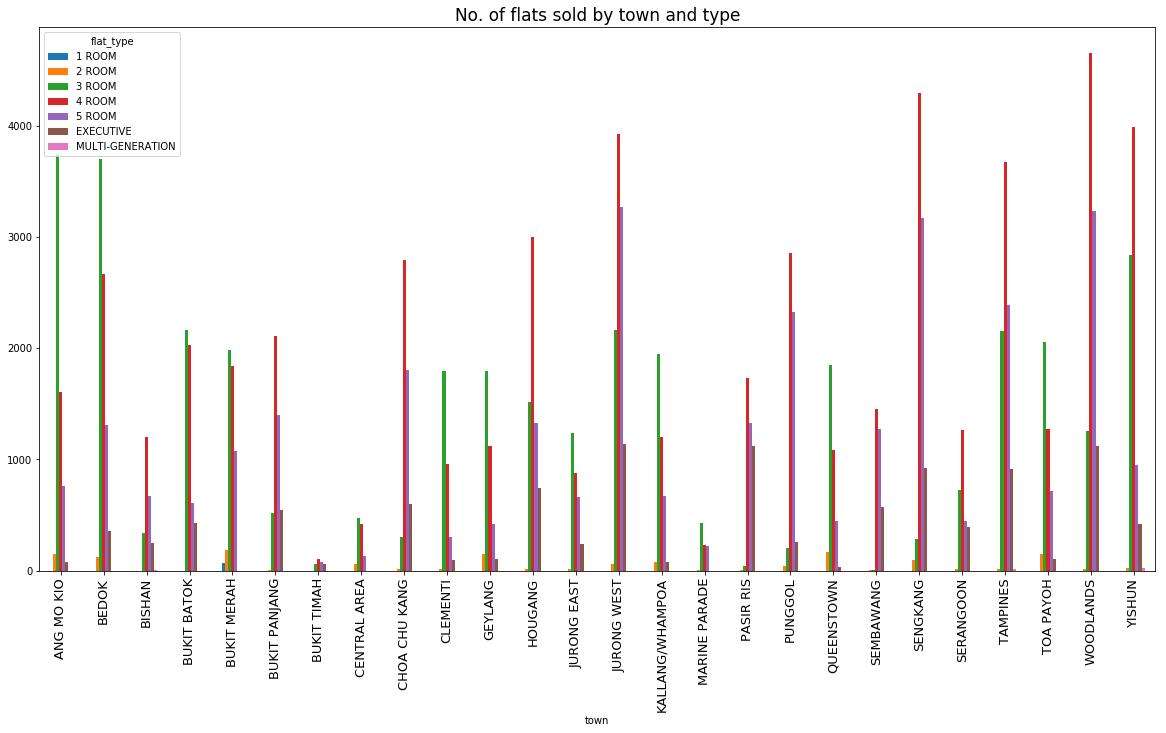

In [88]:
#flat_types vs town
fig,ax = plt.subplots(figsize=(20,10))
subset_type_town = data.groupby(['town','flat_type'])['resale_price'].count().reset_index()
subset_type_town.pivot(index = 'town', columns = 'flat_type',values='resale_price').plot.bar(ax = ax)
plt.title('No. of flats sold by town and type', fontsize = 17)
plt.xticks(fontsize=13)
plt.show()

In [63]:
#Relationship between prices and the no. of units sold?
subset_group = data.groupby(['flat_type'])['resale_price']
np.corrcoef(subset_group.mean(), subset_group.count())

array([[ 1.        , -0.04491625],
       [-0.04491625,  1.        ]])

<b>Insights: </b>The differences between different flat types are even stronger than between towns. A clear ranking can be seen. Variance for each flat_type seems to be less pronounced, showing that same flat_types are priced similarly across Singapore. 

#### e. Looking at categorical data - by Storey Range

Text(0.5,1,'No. of units sold by storey range')

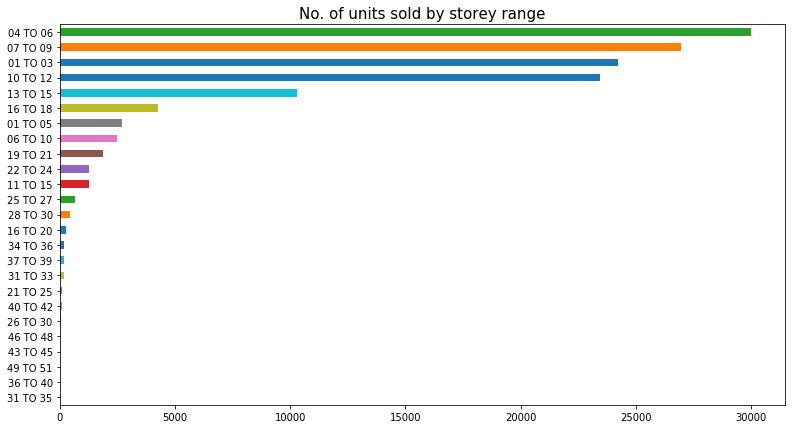

In [64]:
#How many units sold?
fig, ax = plt.subplots(figsize=(13,7))
data['storey_range'].value_counts().sort_values(ascending=True).plot.barh()
plt.title('No. of units sold by storey range', fontsize=15)

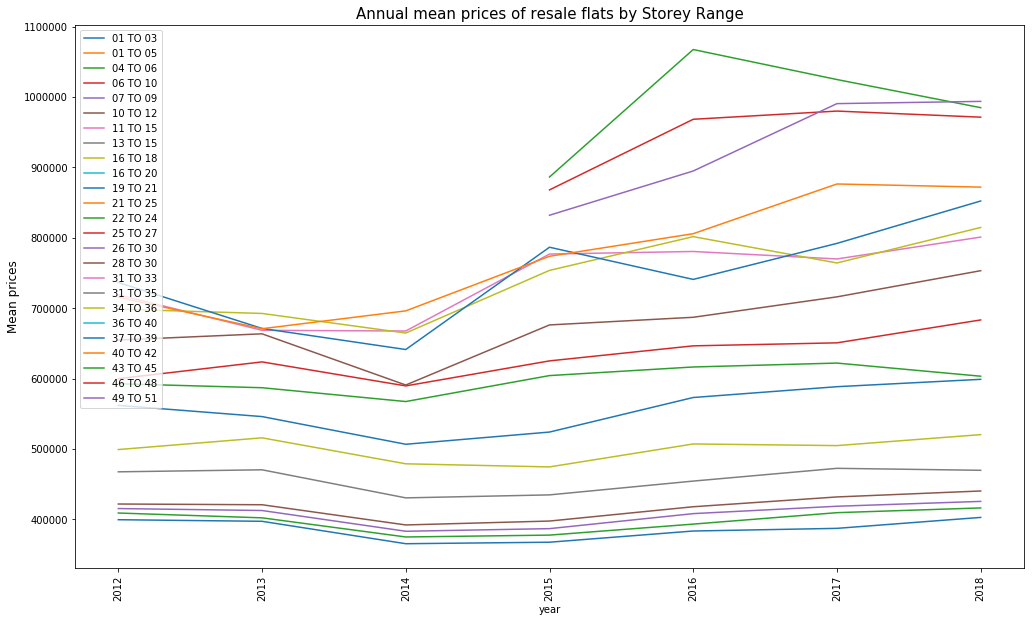

In [65]:
#Any differences in prices of flats by storey_range?
fig, ax = plt.subplots(figsize=(17,10))
by_storey = data.groupby(['storey_range','year'])['resale_price'].mean()
by_storey.reset_index().pivot(index='year',columns='storey_range',values='resale_price').plot.line(ax=ax)
plt.title('Annual mean prices of resale flats by Storey Range', fontsize=15)
plt.ylabel('Mean prices', fontsize =12)
plt.xticks(range(2012,2019), rotation=90)
plt.legend(loc = 'upper left')
plt.show()

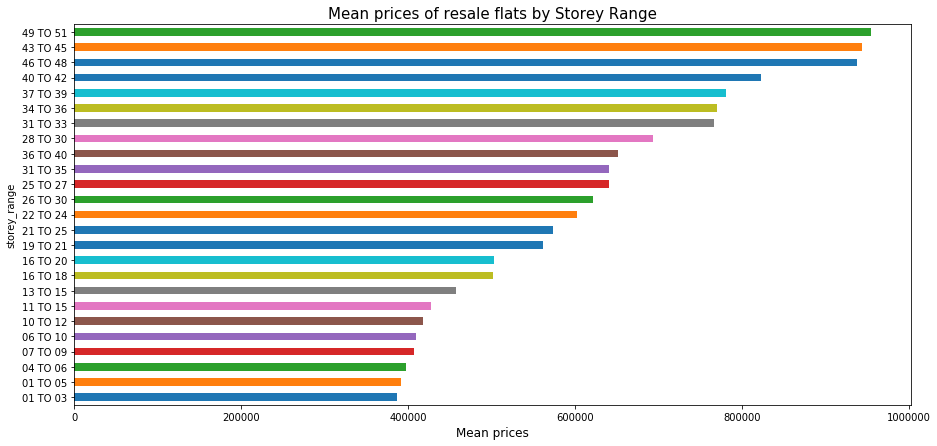

In [66]:
#Are higher flats more expensive in general?
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['storey_range'])['resale_price'].mean().sort_values().plot.barh()
plt.title('Mean prices of resale flats by Storey Range', fontsize=15)
plt.xlabel('Mean prices', fontsize =12)
plt.show()

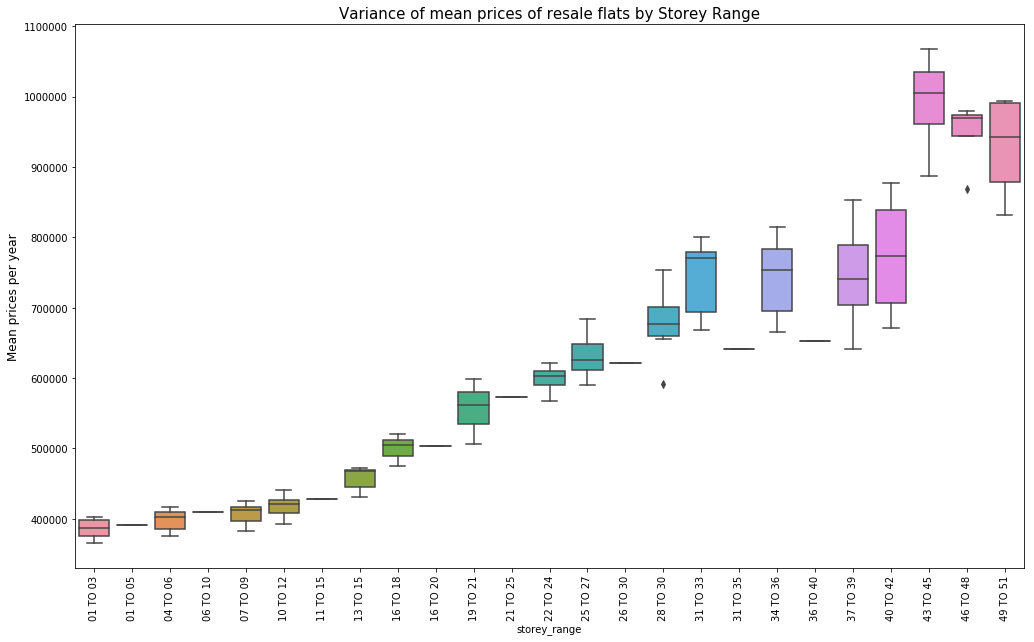

In [67]:
#Variance of prices
fig, ax = plt.subplots(figsize=(17,10))
subset_group = data.groupby(['storey_range','year'])[['resale_price']].mean().reset_index()
sns.boxplot(data = subset_group.pivot(index='year',columns='storey_range',values='resale_price'))
plt.title('Variance of mean prices of resale flats by Storey Range', fontsize=15)
plt.ylabel('Mean prices per year', fontsize =12)
plt.xticks(rotation=90)
plt.show()

In [68]:
#Relationship between prices and the no. of units sold?
subset_group = data.groupby(['storey_range'])['resale_price']
np.corrcoef(subset_group.mean(), subset_group.count())

array([[ 1.        , -0.58966135],
       [-0.58966135,  1.        ]])

<b>Insights: </b>A clear ranking can be seen here as well, with higher up units being sold less, but are generally more expensive than lower ones. There are some cases where the trend is reversed however. There is still enough variance for the prices between different storey ranges to overlap, so storey_range still cannot be used as the sole predictor of flat prices. Interestingly, for the 3 classes covering storeys 43 to 51, the price over time graph starts after 2015, indicating only newer flats go that high. 

#### f. Looking at categorical data - by Flat Model

Text(0.5,1,'No. of units sold by model')

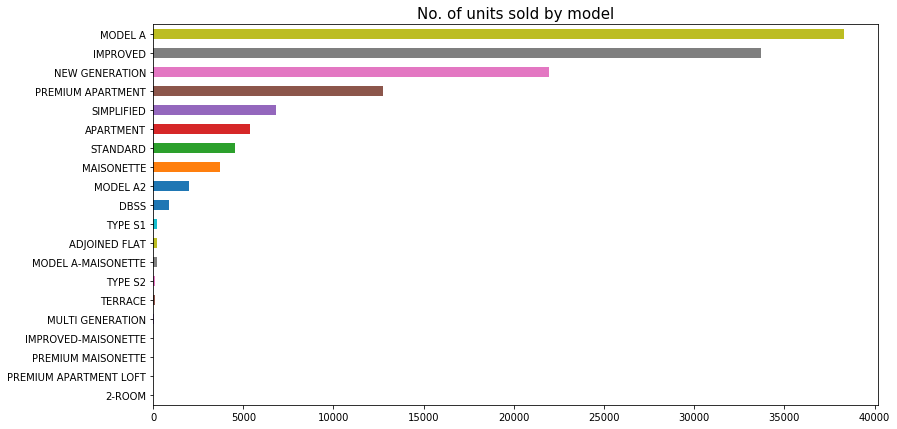

In [69]:
#How many units sold?
fig, ax = plt.subplots(figsize=(13,7))
data['flat_model'].value_counts().sort_values(ascending=True).plot.barh()
plt.title('No. of units sold by model', fontsize=15)

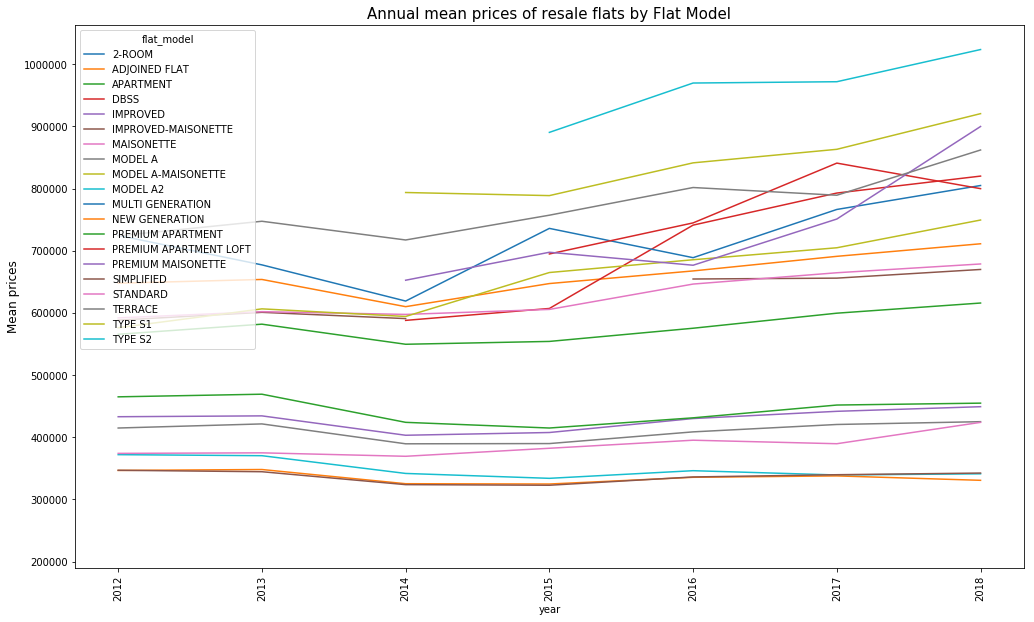

In [70]:
#Any differences in prices of flats by flat_model?
fig, ax = plt.subplots(figsize=(17,10))
by_model = data.groupby(['flat_model','year'])['resale_price'].mean()
by_model.reset_index().pivot(index='year',columns='flat_model',values='resale_price').plot.line(ax=ax)
plt.title('Annual mean prices of resale flats by Flat Model', fontsize=15)
plt.ylabel('Mean prices', fontsize =12)
plt.xticks(range(2012,2019), rotation=90)
plt.show()

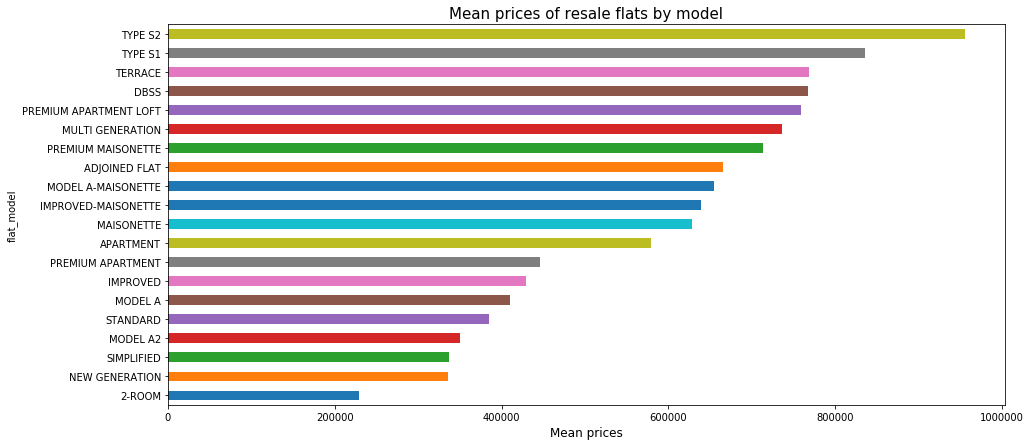

In [71]:
#Most expensive flat models??
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['flat_model'])['resale_price'].mean().sort_values().plot.barh()
plt.title('Mean prices of resale flats by model', fontsize=15)
plt.xlabel('Mean prices', fontsize =12)
plt.show()

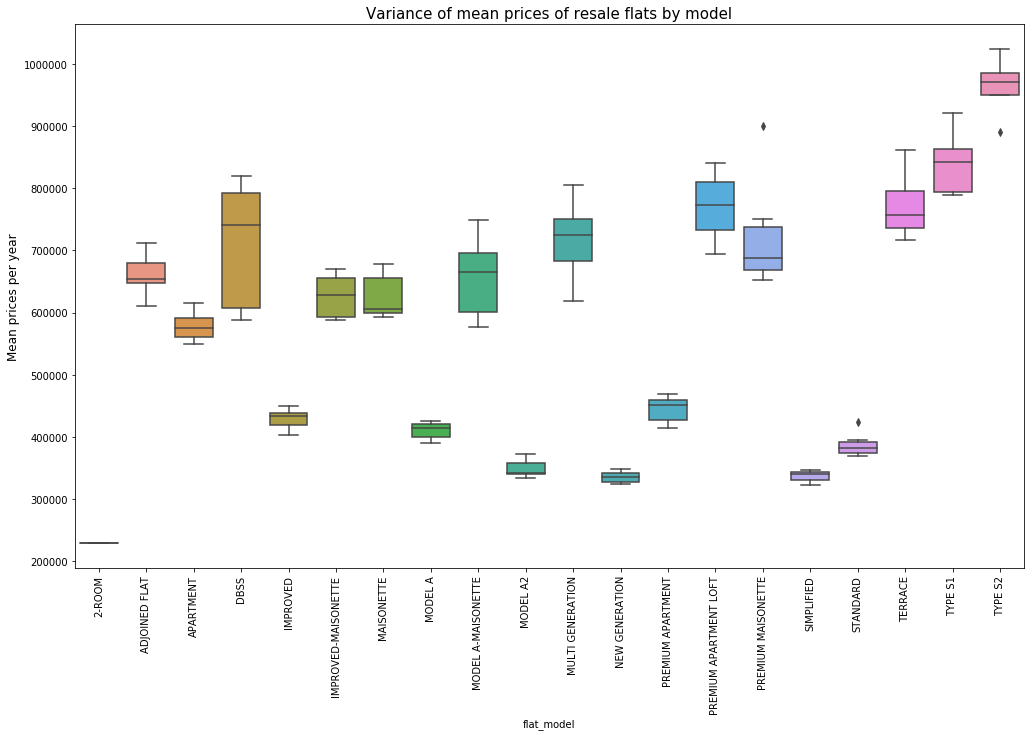

In [72]:
#Variance of prices by different towns from 2005 to 2018
fig, ax = plt.subplots(figsize=(17,10))
subset_group = data.groupby(['flat_model','year'])[['resale_price']].mean().reset_index()
sns.boxplot(data = subset_group.pivot(index='year',columns='flat_model',values='resale_price'))
plt.title('Variance of mean prices of resale flats by model', fontsize=15)
plt.ylabel('Mean prices per year', fontsize =12)
plt.xticks(rotation=90)
plt.show()

In [73]:
#Relationship between prices and the no. of units sold?
subset_group = data.groupby(['flat_model'])['resale_price']
np.corrcoef(subset_group.mean(), subset_group.count())

array([[ 1.        , -0.48419225],
       [-0.48419225,  1.        ]])

<b>Insights: </b>The bar chart indicates differences between the different flat models, showing some relationship between models and price. However, the boxplot shows that the relationships aren't necessarily what we'd expect. There's not much difference between maisonette and improved-maisonette, for example, with the improved model even containing lower minimum values. Premium Apartments also seem to be sold at lower values than normal apartments. Unlike other categorical variables, there's less relation between no. of units sold and prices as well.